In [1]:
from scipy.special import expit
from rbmpy.rbm import RBM
from rbmpy.sampler import DirtyCorrectionMulDimSampler,VanillaSampler,ContinuousSampler,ContinuousApproxSampler, ContinuousApproxMulDimSampler, ApproximatedSampler, LayerWiseApproxSampler,ApproximatedMulDimSampler
from rbmpy.trainer import VanillaTrainier
from rbmpy.performance import Result
import numpy as np
import rbmpy.datasets, rbmpy.performance, rbmpy.plotter, pickle, rbmpy.rbm, os, logging, rbmpy.sampler,math
import math
from rbmpy.rbm import weights_into_hiddens
from rbmpy.progress import Progress

import rbmpy.plotter as pp
from numpy import newaxis
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

logger = logging.getLogger()
# Set the logging level to logging.DEBUG 
logger.setLevel(logging.INFO)

%matplotlib inline

In [2]:
#load the data
import glob
result_file_name = glob.glob("Results/2607241/*")


raw_data = []
for result in result_file_name:
    with open(result,"rb") as f:
        raw_data.append(pickle.load(f))

In [3]:
def get_data(size):
    mnist_data = dict()
    for i in range(1,10):
        ds = np.load("datasets/{}.npy".format(i))[:size]
        try:
            with open("models/{}_models".format(i), 'rb') as f:
                model = pickle.load(f)
            mnist_data[i] = (model, ds)
        except FileNotFoundError:
            logging.warn("There is no model for {}".format(i))
    return mnist_data

# Structure of data

```{(n,m) => {'ORBM_RECONS':..,'RBM_RECONS':..., 'model_ids':(n,m),'DS_COMP':... }}```



In [383]:


class Result(object):
    
    def __init__(self):
        self.orbm_a_recons = {}
        self.orbm_b_recons = {}
        self.rbm_a_recons  = {}
        self.rbm_b_recons  = {}
        
        self.orbm_a_scores = {}
        self.orbm_b_scores = {}
        self.rbm_a_scores = {}
        self.rbm_b_scores = {}
        
    def safe_add(self, key, value, score_dict):
        if key not in score_dict:
            score_dict[key] = []
        score_dict[key].append(value)
    
    
    def add_scores(self,model_ids, orbm_a_recons, orbm_b_recons, rbm_a_recons, rbm_b_recons,orbm_a, orbm_b, rbm_a,rbm_b):
        self.safe_add(model_ids, orbm_a_recons, self.orbm_a_recons)
        self.safe_add(model_ids, orbm_b_recons, self.orbm_b_recons)
        self.safe_add(model_ids, rbm_a_recons, self.rbm_a_recons)
        self.safe_add(model_ids, rbm_b_recons, self.rbm_b_recons)
        
        self.safe_add(model_ids, orbm_a, self.orbm_a_scores)
        self.safe_add(model_ids, orbm_b, self.orbm_b_scores)
    
        self.safe_add(model_ids, rbm_a, self.rbm_a_scores)
        self.safe_add(model_ids, rbm_b, self.rbm_b_scores)
    
    def hightest_scores(key, n):
        """Grab the n highest values from the key thing"""
        pass
    
    
    def ndarrayify(self, score_dict):
        nd_score_dict = {}
        for key in score_dict:
            nd_score_dict[key] = np.array(score_dict[key])
        return nd_score_dict

    def mean_scores(self):
        or_a = self.ndarrayify(self.orbm_a_scores)
        or_b = self.ndarrayify(self.orbm_b_scores)
        r_a  = self.ndarrayify(self.rbm_a_scores)
        r_b  = self.ndarrayify(self.rbm_b_scores)
    
        or_a = {k: v.mean(axis = 0) for k, v in or_a.items()}
        or_b = {k: v.mean(axis = 0) for k, v in or_b.items()}
        r_a  = {k: v.mean(axis = 0) for k, v in r_a.items()}
        r_b  = {k: v.mean(axis = 0) for k, v in r_b.items()}
        
        return or_a, or_b, r_a, r_b
    
    def matrix_for_scores(self,scores):
        x_idx, y_idx = list(map(list, zip(*scores.keys())))

        matrix = np.ones(shape=(max(x_idx)+1, max(y_idx)+1))
        for key in scores:
            matrix[key[0],key[1]] = scores[key].sum()

        return matrix
    
    def mean_score_matrices(self):
        or_a, or_b, r_a, r_b = self.mean_scores()
        
        return self.matrix_for_scores(or_a), self.matrix_for_scores(or_b), self.matrix_for_scores(r_a), self.matrix_for_scores(r_b)
    
def ll_image_wise_score(v, v_prime):
#     return (v * np.log(v_prime)).sum(1)
    return -(abs(v - v_prime))

    
def unzip_and_ndarrays(list_of_2d_tuple):
    a = list(map(list, zip(*list_of_2d_tuple)))
    return np.array(a[0]), np.array(a[1])
       
def scores_for_recons(target_recons,orbm_recons, rbm_recons):
    
    target_a_recons, target_b_recons = target_recons
    
    orbm_a_recons, orbm_b_recons = unzip_and_ndarrays(orbm_recons)
    rbm_a_recons, rbm_b_recons = unzip_and_ndarrays(rbm_recons)
    # Calculate the scores
    orbm_a_score = ll_image_wise_score(target_a_recons, orbm_a_recons)
    orbm_b_score = ll_image_wise_score(target_b_recons, orbm_b_recons)
    rbm_a_score = ll_image_wise_score(target_a_recons, rbm_a_recons)
    rbm_b_score = ll_image_wise_score(target_b_recons, rbm_b_recons)
    return orbm_a_recons, orbm_b_recons,rbm_a_recons, rbm_b_recons ,orbm_a_score, orbm_b_score, rbm_a_score, rbm_b_score

<img src = "Assets/LL_Score.png">

In [384]:
mnist_data = get_data(None)

In [385]:
def ds_from_mnist_ids(key, size):
    a_data = mnist_data[key[0]][1][:size]
    b_data = mnist_data[key[1]][1][:size]
    return rbmpy.datasets.flatten_data_set(a_data),rbmpy.datasets.flatten_data_set(b_data)

In [386]:
# # def scores_for_recons(target_recons,obrm_recons, rbm_recons, flattened_ds_comp)
# temp_orbm = raw_data[0][(1,1)]["ORBM_RECONS"] 
# temp_rbm = raw_data[0][(1,1)]["RBM_RECONS"]
# temp_ds_comp = raw_data[0][(1,1)]["DS_COMP"].reshape(temp_ds_comp.shape[0], temp_ds_comp.shape[1] * temp_ds_comp.shape[2])
# scores_for_recons((temp_ds_comp,temp_ds_comp),temp_orbm,temp_rbm, temp_ds_comp)[0].shape
# flattened_ds_comp = ds_comp.reshape(ds_comp.shape[0], ds_comp.shape[1] * ds_comp.shape[2])

In [387]:
result = Result()
for run in raw_data:
    for key in run:
        current_comp = run[key]
        orbm_recons = current_comp["ORBM_RECONS"]
        rbm_recons = current_comp["RBM_RECONS"]
        
        size = current_comp["DS_COMP"].shape[0]
        target_recons = ds_from_mnist_ids(key, size)
        result.add_scores(key, *scores_for_recons(target_recons, orbm_recons,rbm_recons))

In [388]:
a = result.mean_scores()
o_a, o_b, r_a, r_b = result.mean_score_matrices()

In [389]:
def plot_matrix(m, ticks):
    plt.imshow(m, interpolation='nearest',cmap=plt.cm.RdYlBu)
    plt.xticks(ticks)
    plt.yticks(ticks)
    plt.colorbar()
    plt.show()

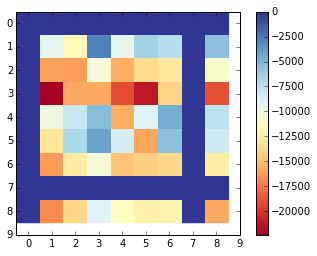

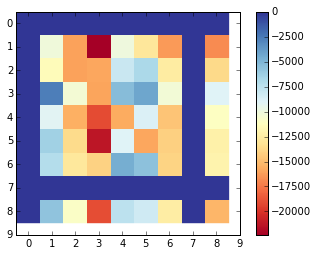

In [390]:
ticks = np.arange(10)
plot_matrix(o_a - r_a, ticks)
plot_matrix(o_b - r_b, ticks)

In [391]:
49 - np.where(np.isclose((o_b - r_b).T, (o_a - r_a)), 1,0).sum()


17

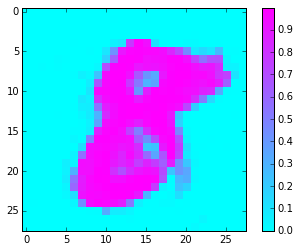

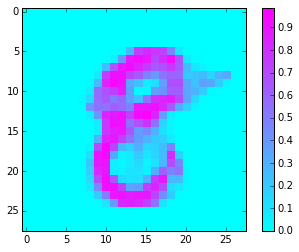

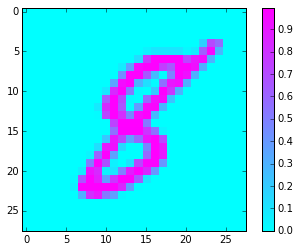

In [392]:
comp = (8,1)
or_score_of_interest = np.array(result.orbm_a_scores[comp])
or_recon_of_interest = np.array(result.orbm_a_recons[comp])

r_score_of_interest = np.array(result.rbm_a_scores[comp])
r_recon_of_interest = np.array(result.rbm_a_recons[comp])

or_max_idx = np.unravel_index(or_score_of_interest.argmax(), or_score_of_interest.shape)
r_max_idx  = np.unravel_index(r_score_of_interest.argmax(), r_score_of_interest.shape)

pp.image(or_recon_of_interest[or_max_idx[0], or_max_idx[1], :].reshape(28,28))
pp.image(r_recon_of_interest[r_max_idx[0], r_max_idx[1], :].reshape(28,28))
pp.image(mnist_data[comp[0]][1][max_idx[1]])